In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import img_to_array
from tensorflow.keras import datasets,models,layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix,classification_report, precision_recall_fscore_support,ConfusionMatrixDisplay
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential, Model


In [2]:
sz=200
size_set=5200
dataX=np.zeros((size_set,sz,sz))
path='data_all/'
for i in range(size_set):
    img = cv2.imread(path+str(i+1).zfill(5)+'.png', cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (sz,sz), interpolation = cv2.INTER_AREA)
    img=img.reshape(1, sz, sz)
    img=img_to_array(img[:,:]) 
    dataX[i,:,:] =img_to_array(img[:,:]) 
dataY = pd.read_csv('label_all.csv')
dataY = pd.DataFrame.to_numpy(dataY)
dataY =dataY.reshape(len(dataY),)
dataY=dataY-1
dataY = to_categorical(dataY,num_classes=5)

In [3]:
def data_split(dataX, dataY):
    X_train, X_test, y_train, y_test = train_test_split(
    dataX, dataY, test_size=0.2, random_state=5)
    return X_train, X_test, y_train, y_test,

In [4]:
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

In [5]:
trainX, testX, trainY, testY=data_split(dataX, dataY)
trainX, testX = prep_pixels(trainX, testX)
trainX = trainX.reshape((trainX.shape[0], sz, sz, 1))
testX = testX.reshape((testX.shape[0], sz, sz, 1))

In [6]:
# Augmentation
train_datagen = ImageDataGenerator(rotation_range=180,  # rotation
                                   horizontal_flip=True,  # horizontal flip
                                   vertical_flip=True)  # brightness

test_datagen = ImageDataGenerator(rotation_range=180,  # rotation
                                   horizontal_flip=True,  # horizontal flip
                                   vertical_flip=True)  # brightness


batch_size =16
train_generator = train_datagen.flow(trainX, trainY, batch_size=batch_size)
test_generator = test_datagen.flow(testX, testY, batch_size=batch_size, shuffle=False)

In [7]:
def plotmodelhistory(history,idname): 
    
    fig=plt.figure(figsize=(10, 5), dpi=300)
#     fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    plt.plot(history.history['accuracy']) 
    plt.plot(history.history['val_accuracy']) 
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy') 
    plt.xlabel('Epoch')
    
    plt.legend(['train', 'validate'], loc='upper left')
    fig.savefig('history_train_'+idname+'.png',dpi=300,pad_inches=0.5,bbox_inches='tight')
    
    fig2=plt.figure(figsize=(10, 5), dpi=300)
    fig2 = plt.gcf()
    # summarize history for loss
    plt.plot(history.history['loss']) 
    plt.plot(history.history['val_loss']) 
    plt.title('Model Loss')
    plt.ylabel('Loss') 
    plt.xlabel('Epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()
    fig2.savefig('history_train_'+idname+'.png',dpi=300,pad_inches=0.5,bbox_inches='tight')

In [8]:
class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [9]:
model = ResNet18(5)
model.build(input_shape = (None,sz,sz,1))
opt = SGD(learning_rate=0.001,momentum=0.9, decay=1e-4) 
model.compile(optimizer = opt,loss='categorical_crossentropy', metrics=["accuracy"]) 

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Epoch 1/80
260/260 [==============================] - 272s 1s/step - loss: 1.2266 - accuracy: 0.4976 - val_loss: 1.1954 - val_accuracy: 0.4875
Epoch 2/80
260/260 [==============================] - 269s 1s/step - loss: 0.7242 - accuracy: 0.7077 - val_loss: 39.8503 - val_accuracy: 0.2048
Epoch 3/80
260/260 [==============================] - 269s 1s/step - loss: 0.5301 - accuracy: 0.7788 - val_loss: 4.5888 - val_accuracy: 0.2471
Epoch 4/80
260/260 [==============================] - 268s 1s/step - loss: 0.4774 - accuracy: 0.8010 - val_loss: 22.2248 - val_accuracy: 0.2798
Epoch 5/80
260/260 [==============================] - 268s 1s/step - loss: 0.4366 - accuracy: 0.8219 - val_loss: 1.2399 - val_accuracy: 0.5356
Epoch 6/80
260/260 [==============================] - 268s 1s/step - loss: 0.4680 - accuracy: 0.8118 - val_loss: 0.4332 - val_accuracy: 0.8096
Epoch 7/80
260/260 [==============================] - 267s 1s/step - loss: 0.4449 - accuracy: 0.8192 - val_loss: 5.2246 - val_accuracy: 0.23

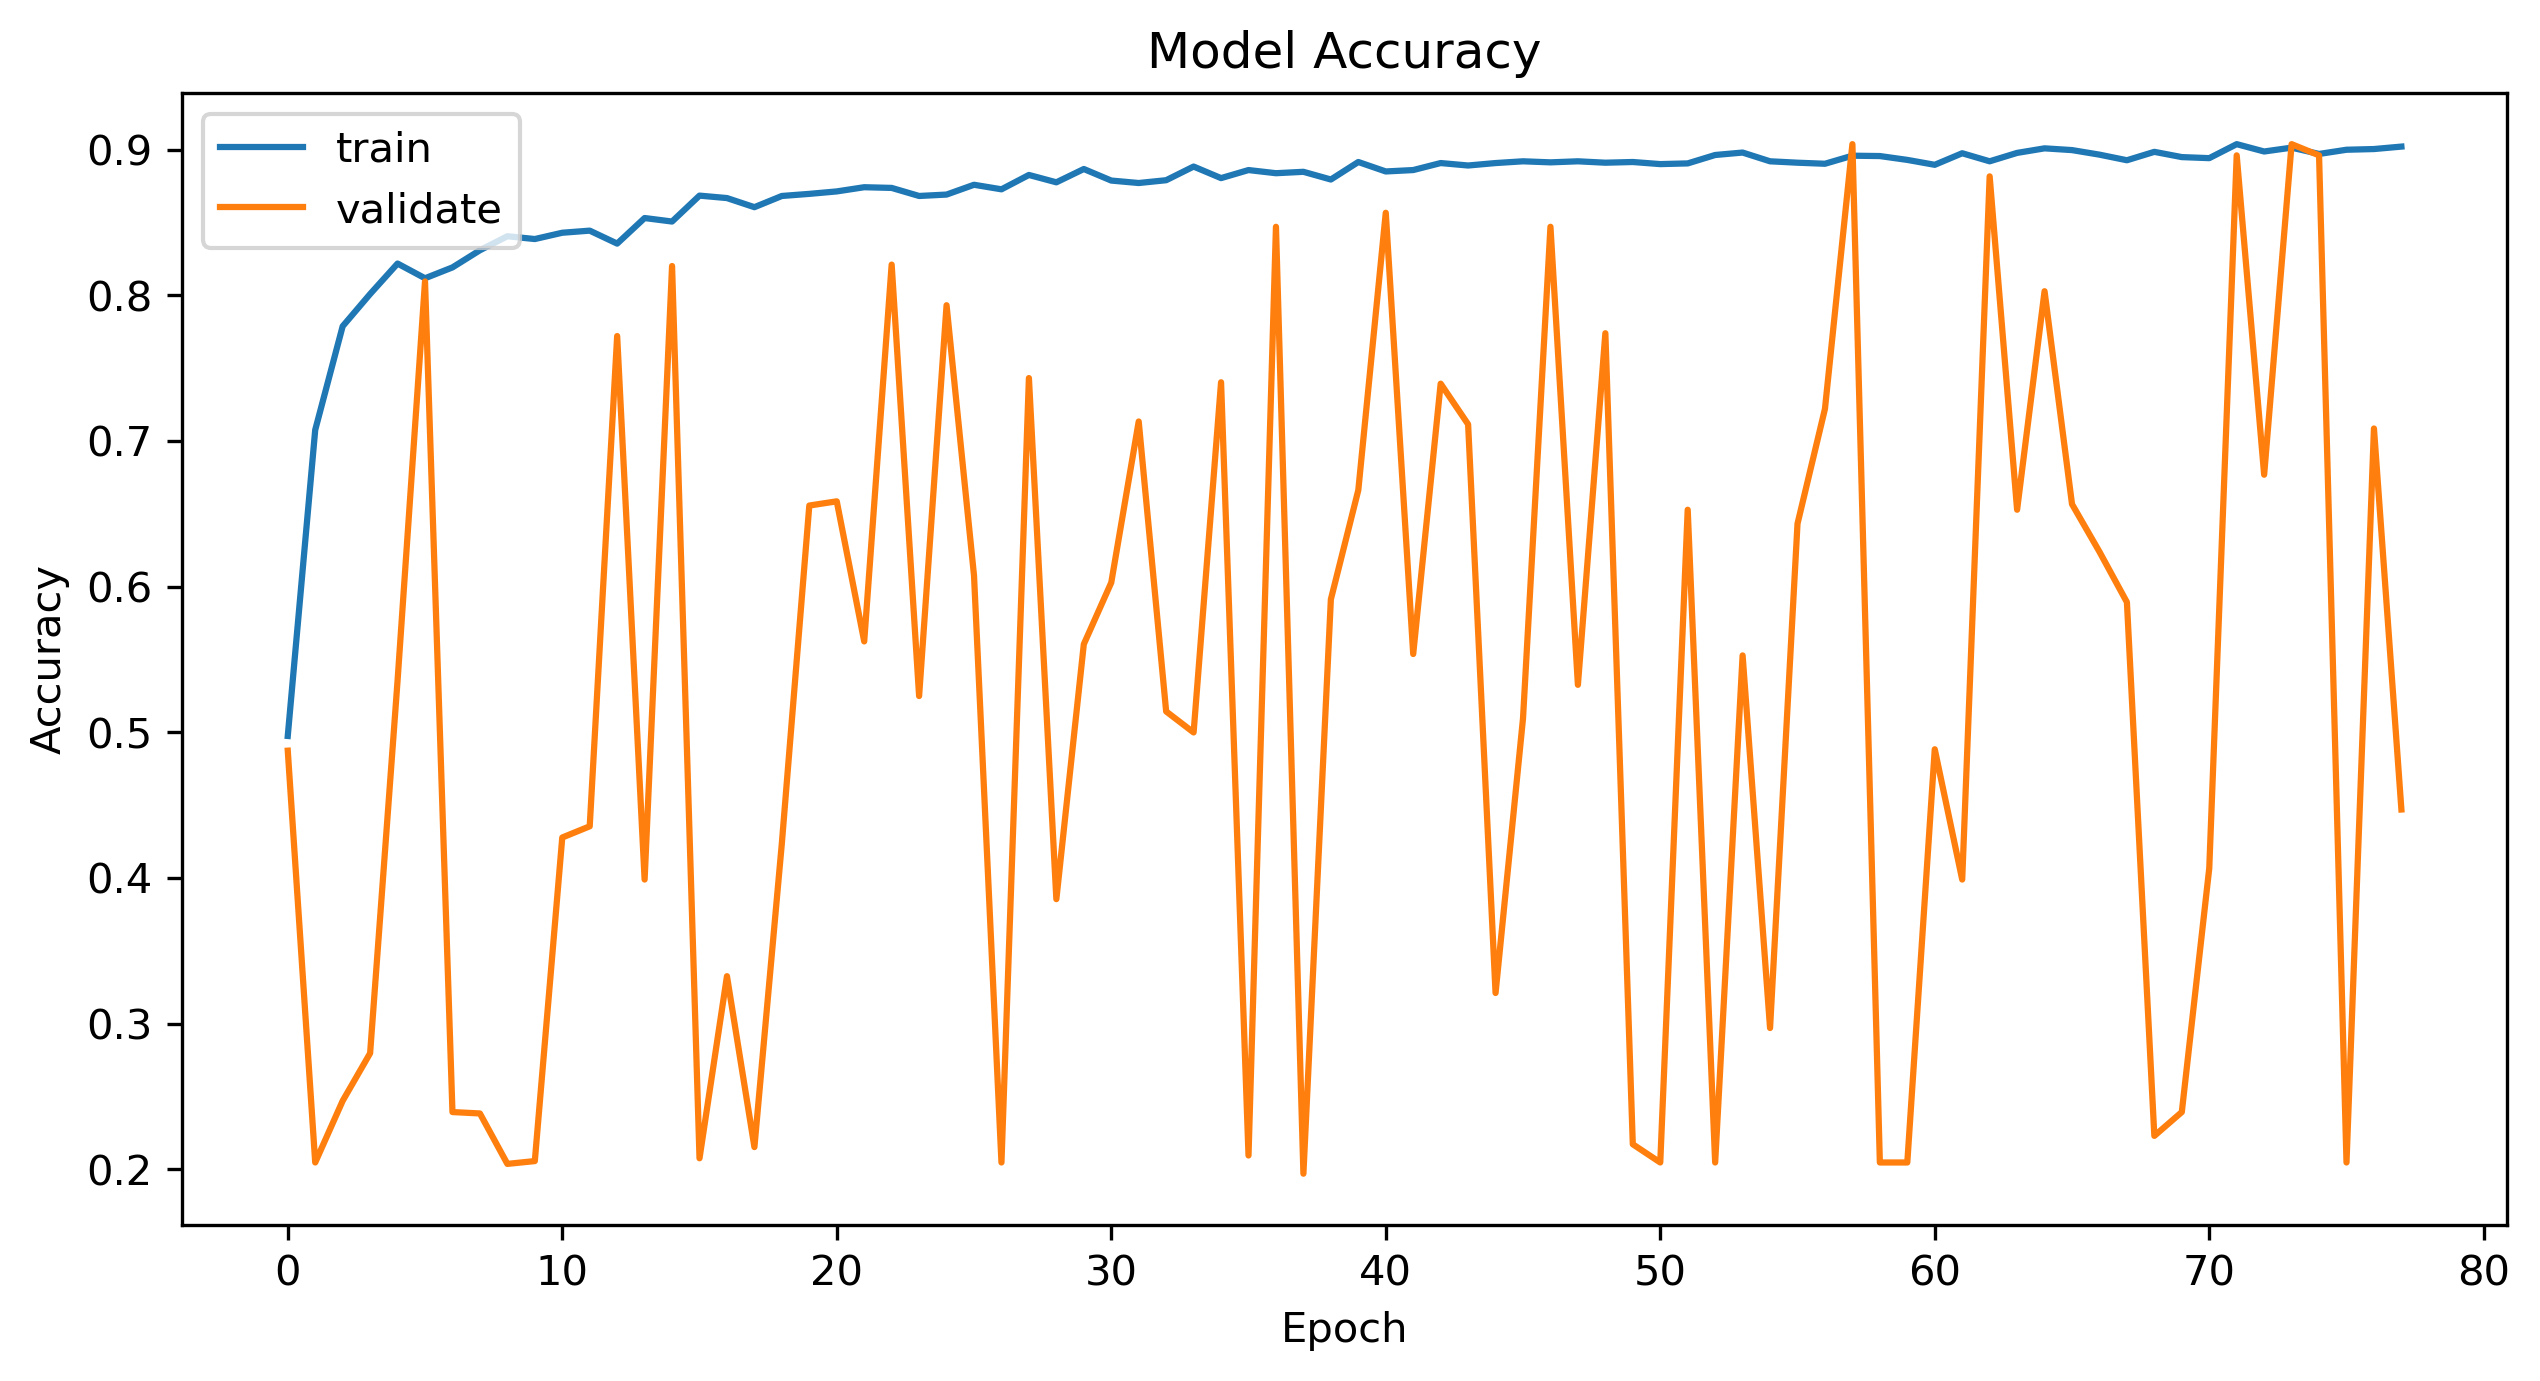

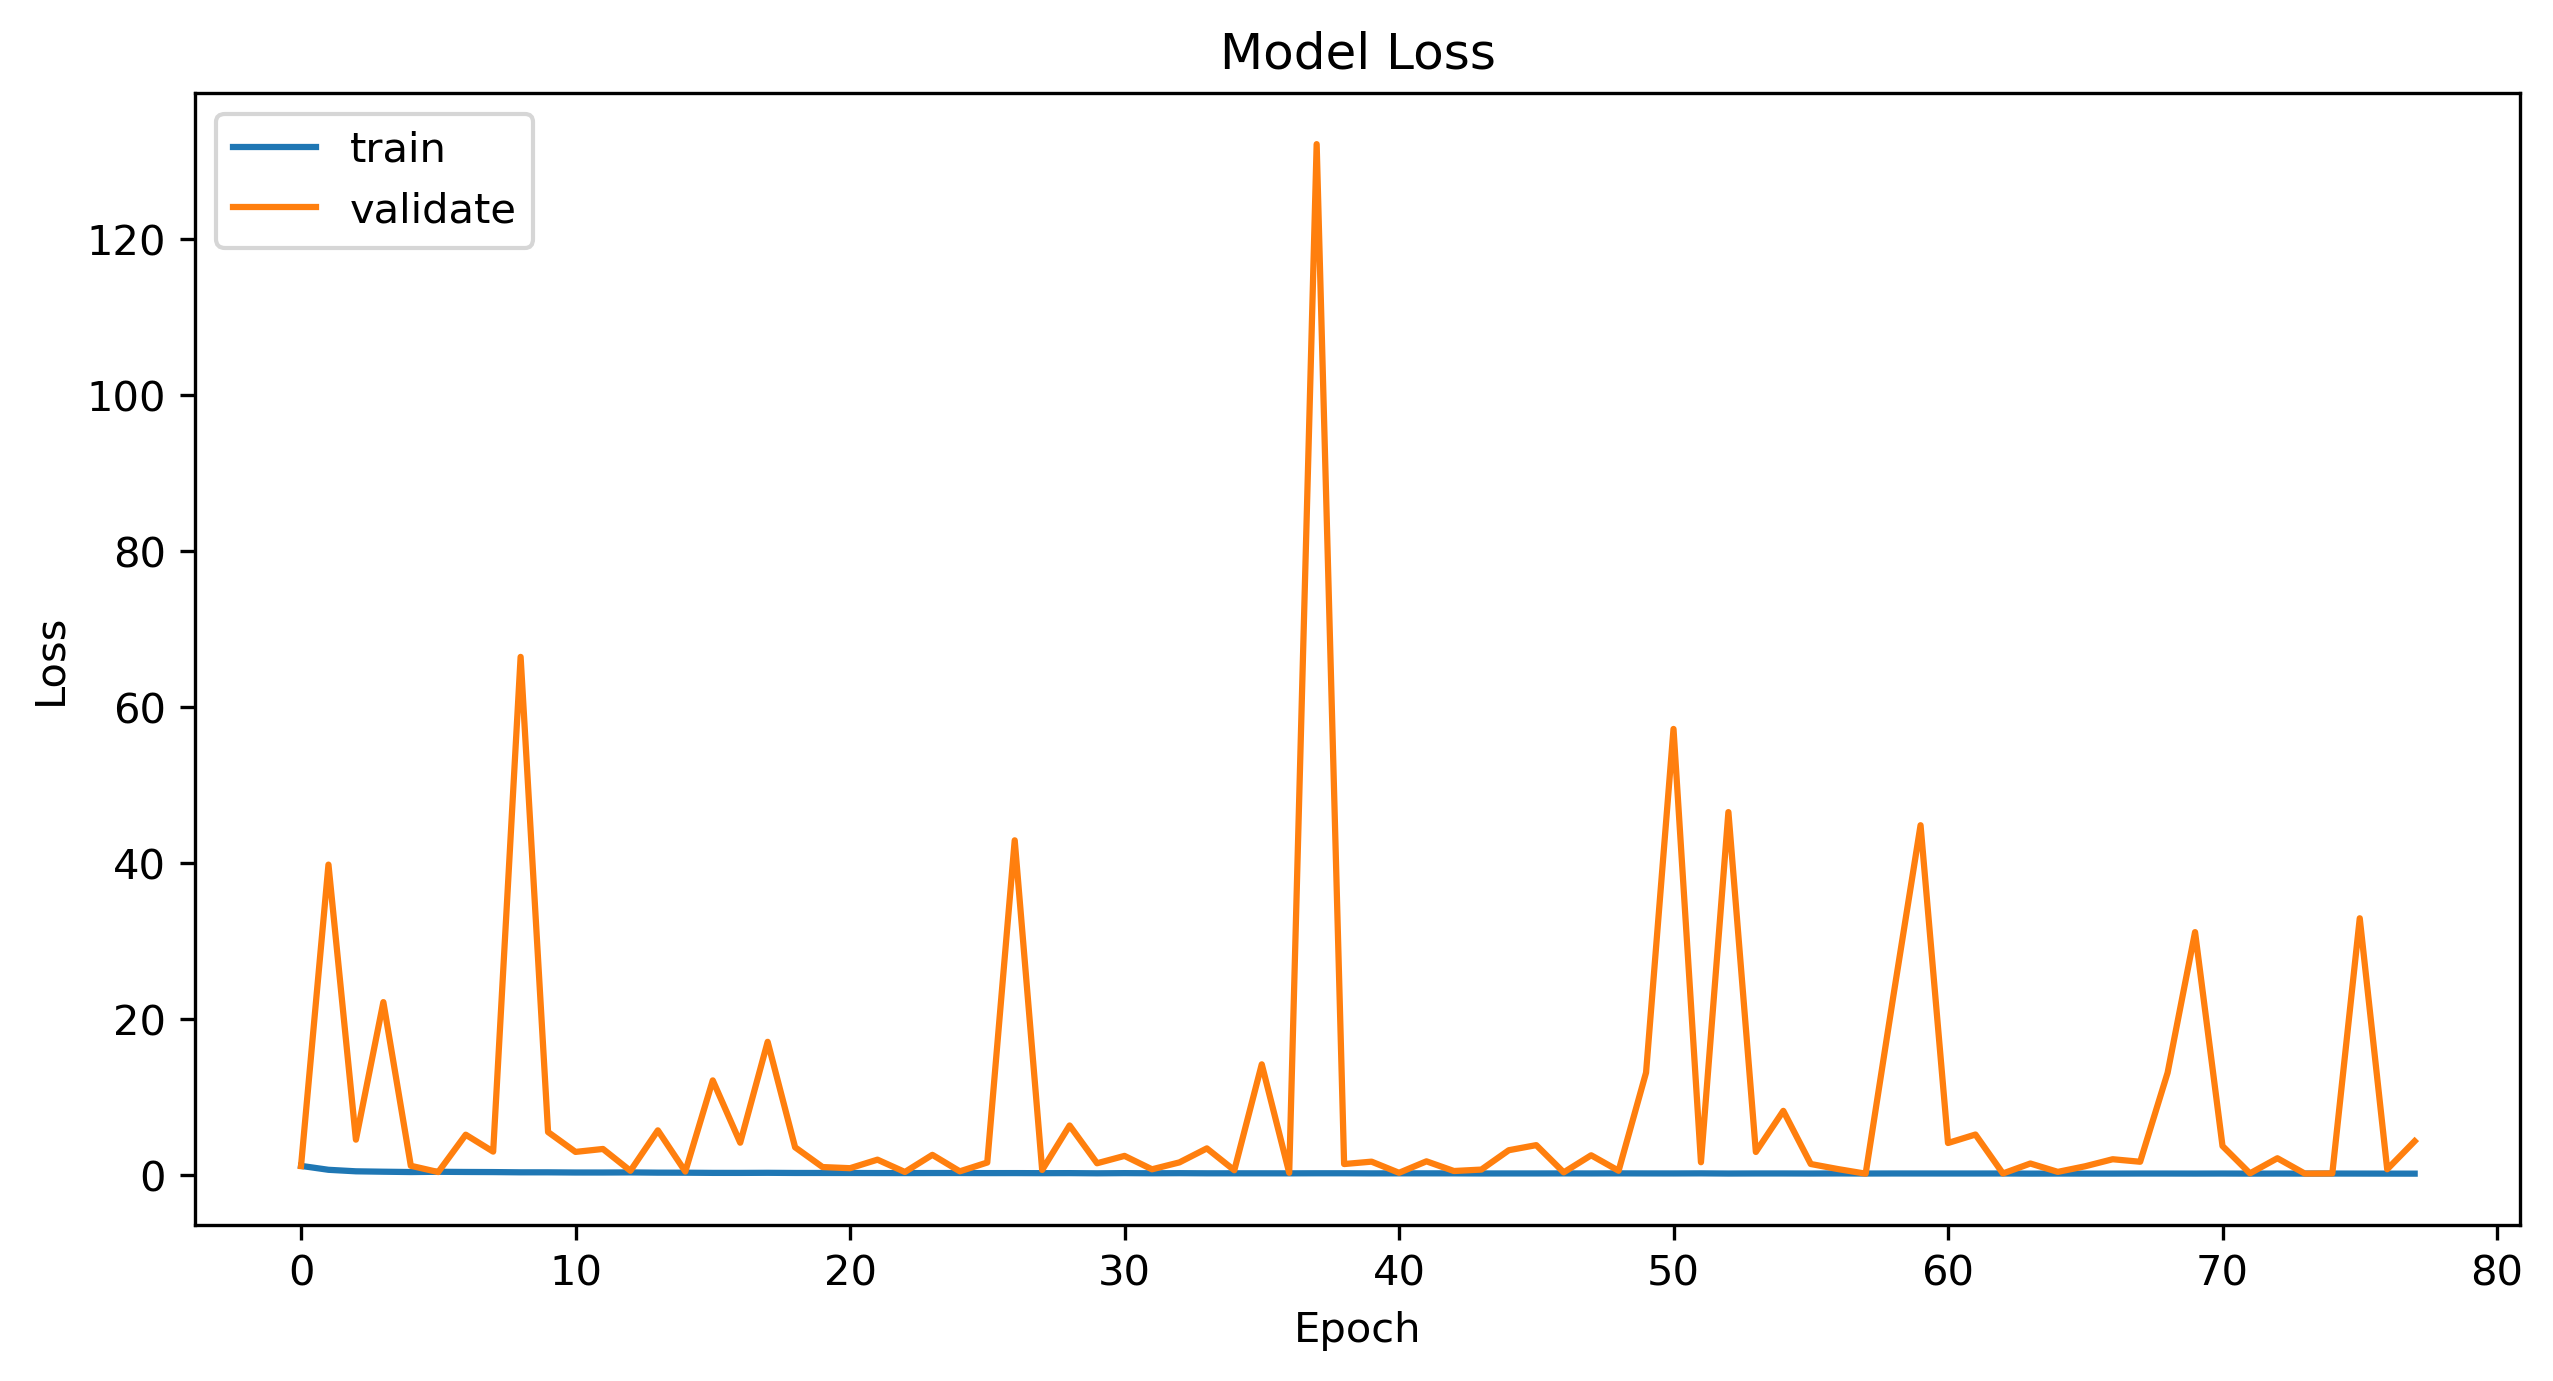

In [10]:
es = EarlyStopping(patience= 40, restore_best_weights=True, monitor="val_accuracy")
STEPS = len(trainX) / sz

history = model.fit(train_generator, batch_size = 16, epochs=80, validation_data=test_generator, callbacks=[es])
model.save_weights('resnet_aug_1.h5')
hist_df = pd.DataFrame(history.history) 
hist_csv_file = 'resnet_aug_history_1.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)
    
print(history.history.keys())
plotmodelhistory(history,'stage_1')


Epoch 1/80
260/260 [==============================] - 268s 1s/step - loss: 0.2415 - accuracy: 0.8981 - val_loss: 0.2087 - val_accuracy: 0.9106
Epoch 2/80
260/260 [==============================] - 267s 1s/step - loss: 0.2307 - accuracy: 0.9002 - val_loss: 0.2198 - val_accuracy: 0.9125
Epoch 3/80
260/260 [==============================] - 268s 1s/step - loss: 0.2369 - accuracy: 0.9000 - val_loss: 0.3057 - val_accuracy: 0.8692
Epoch 4/80
260/260 [==============================] - 268s 1s/step - loss: 0.2288 - accuracy: 0.8993 - val_loss: 0.2141 - val_accuracy: 0.9029
Epoch 5/80
260/260 [==============================] - 268s 1s/step - loss: 0.2350 - accuracy: 0.8986 - val_loss: 0.2080 - val_accuracy: 0.9144
Epoch 6/80
260/260 [==============================] - 268s 1s/step - loss: 0.2282 - accuracy: 0.9029 - val_loss: 0.2376 - val_accuracy: 0.9087
Epoch 7/80
260/260 [==============================] - 267s 1s/step - loss: 0.2359 - accuracy: 0.9000 - val_loss: 0.3391 - val_accuracy: 0.8538

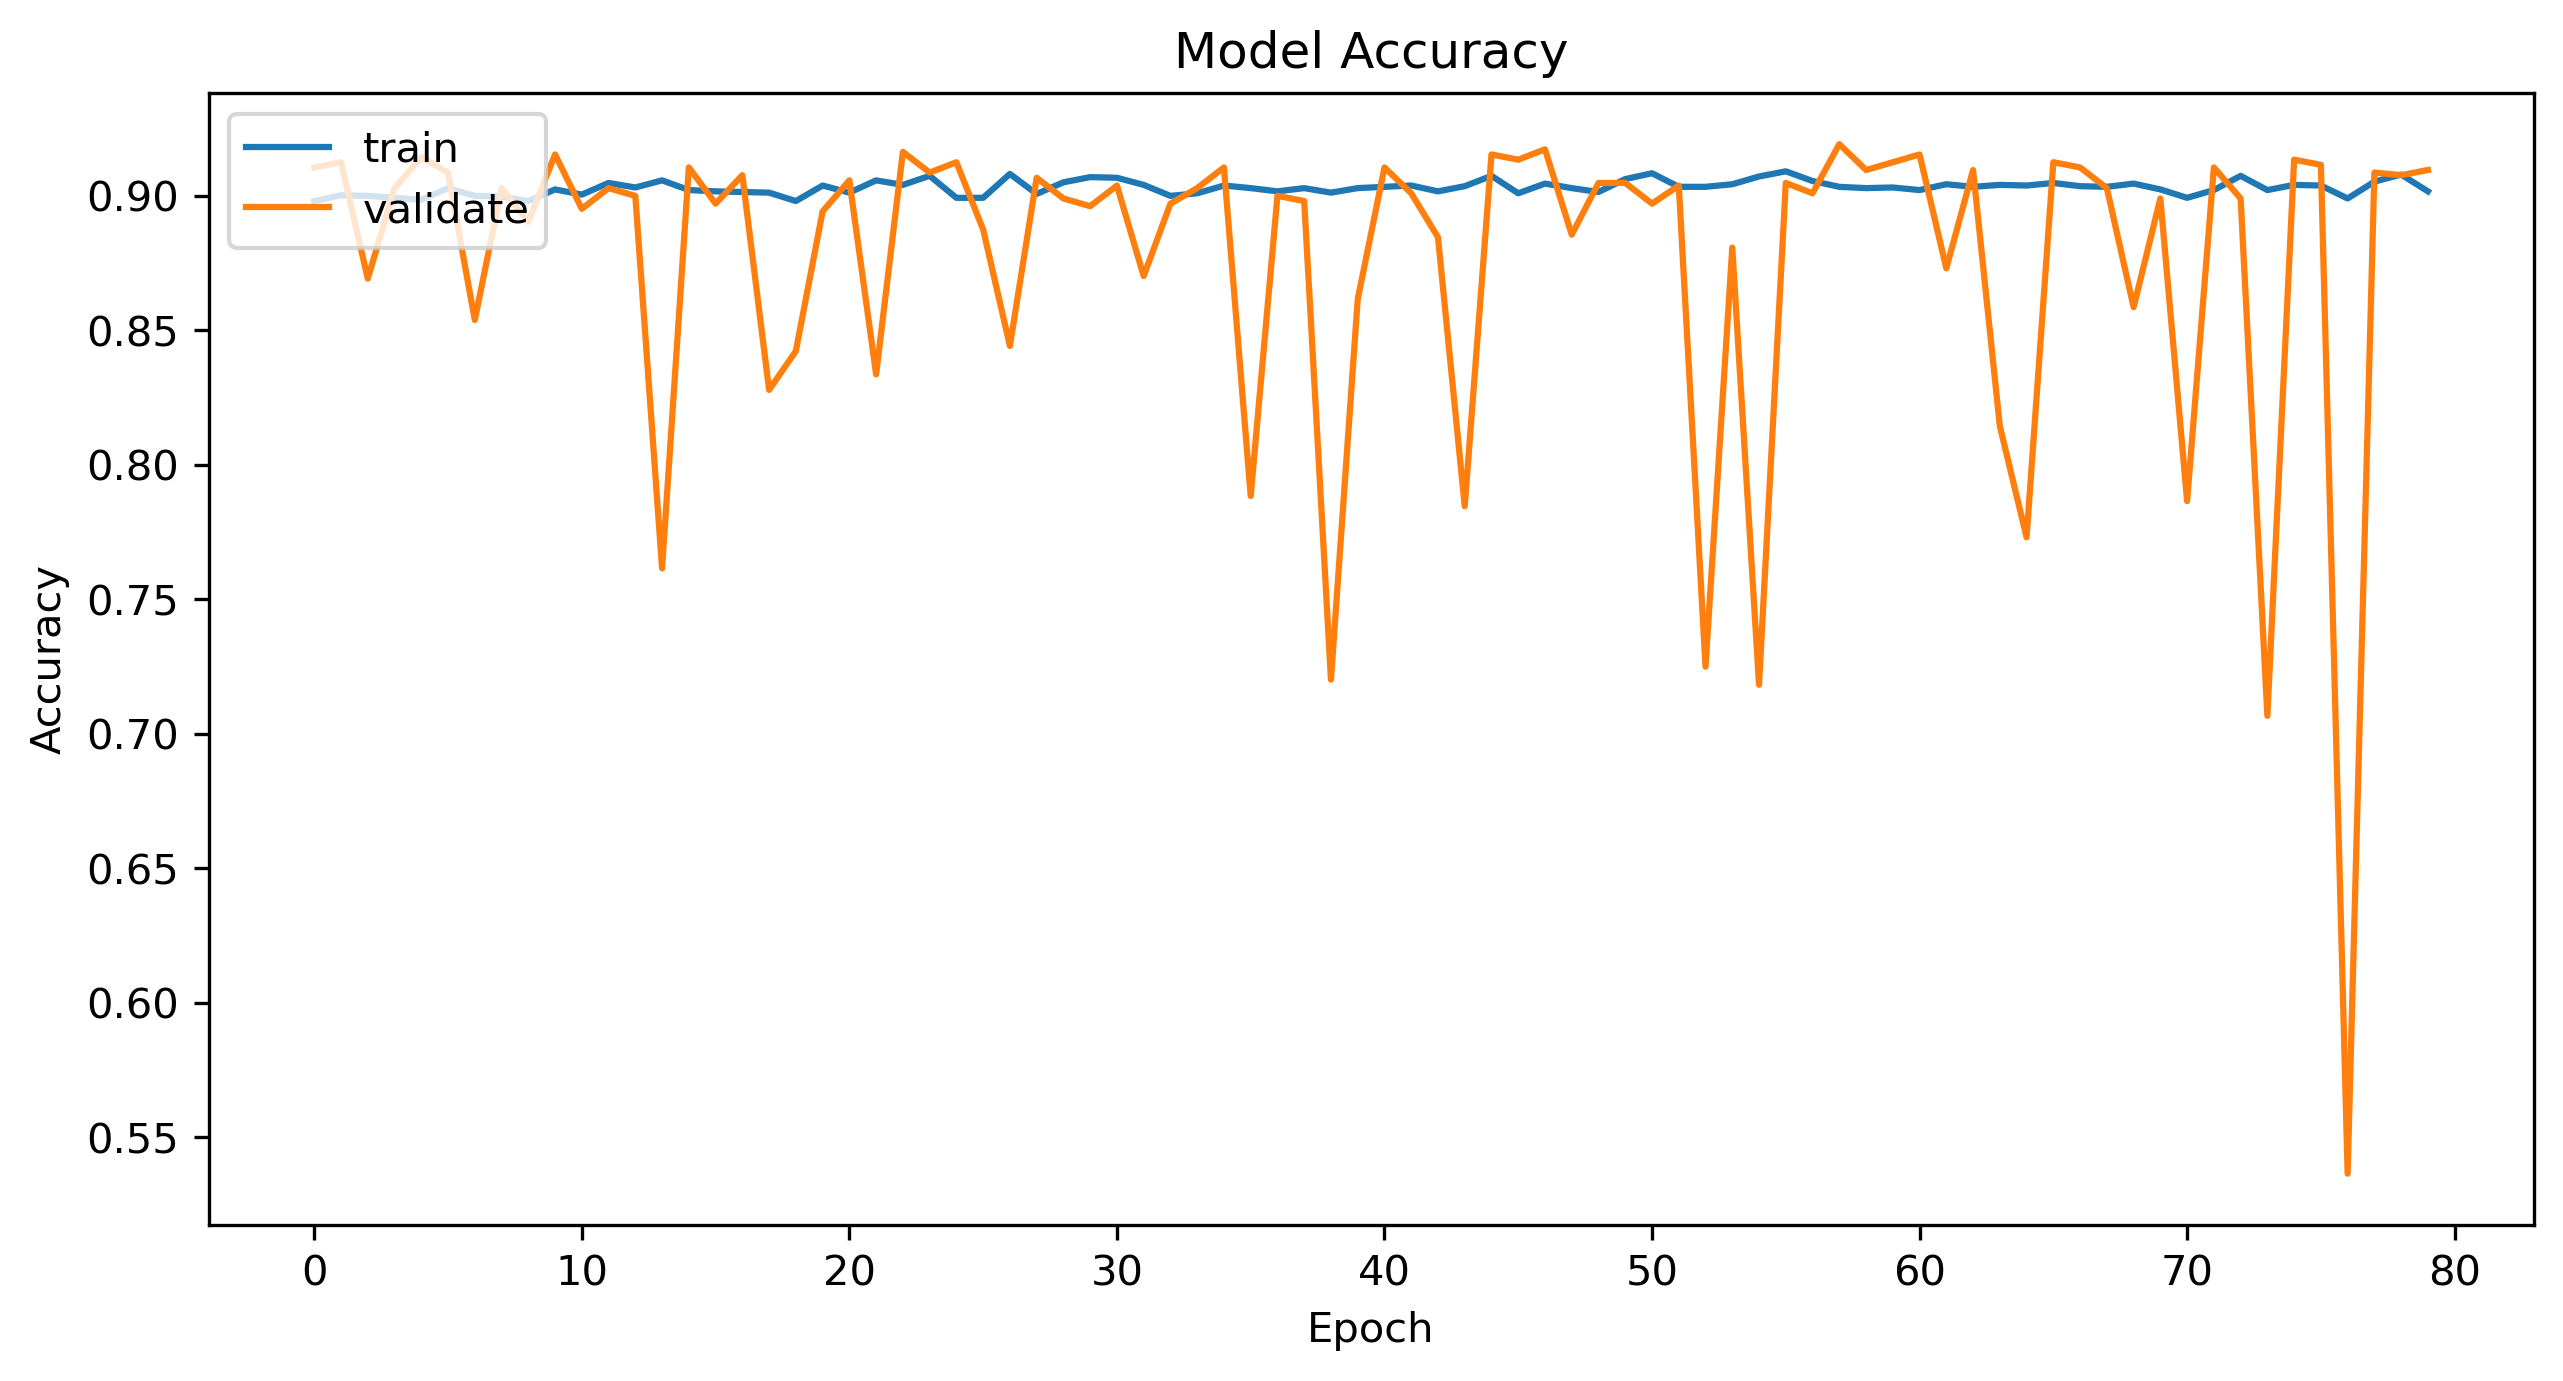

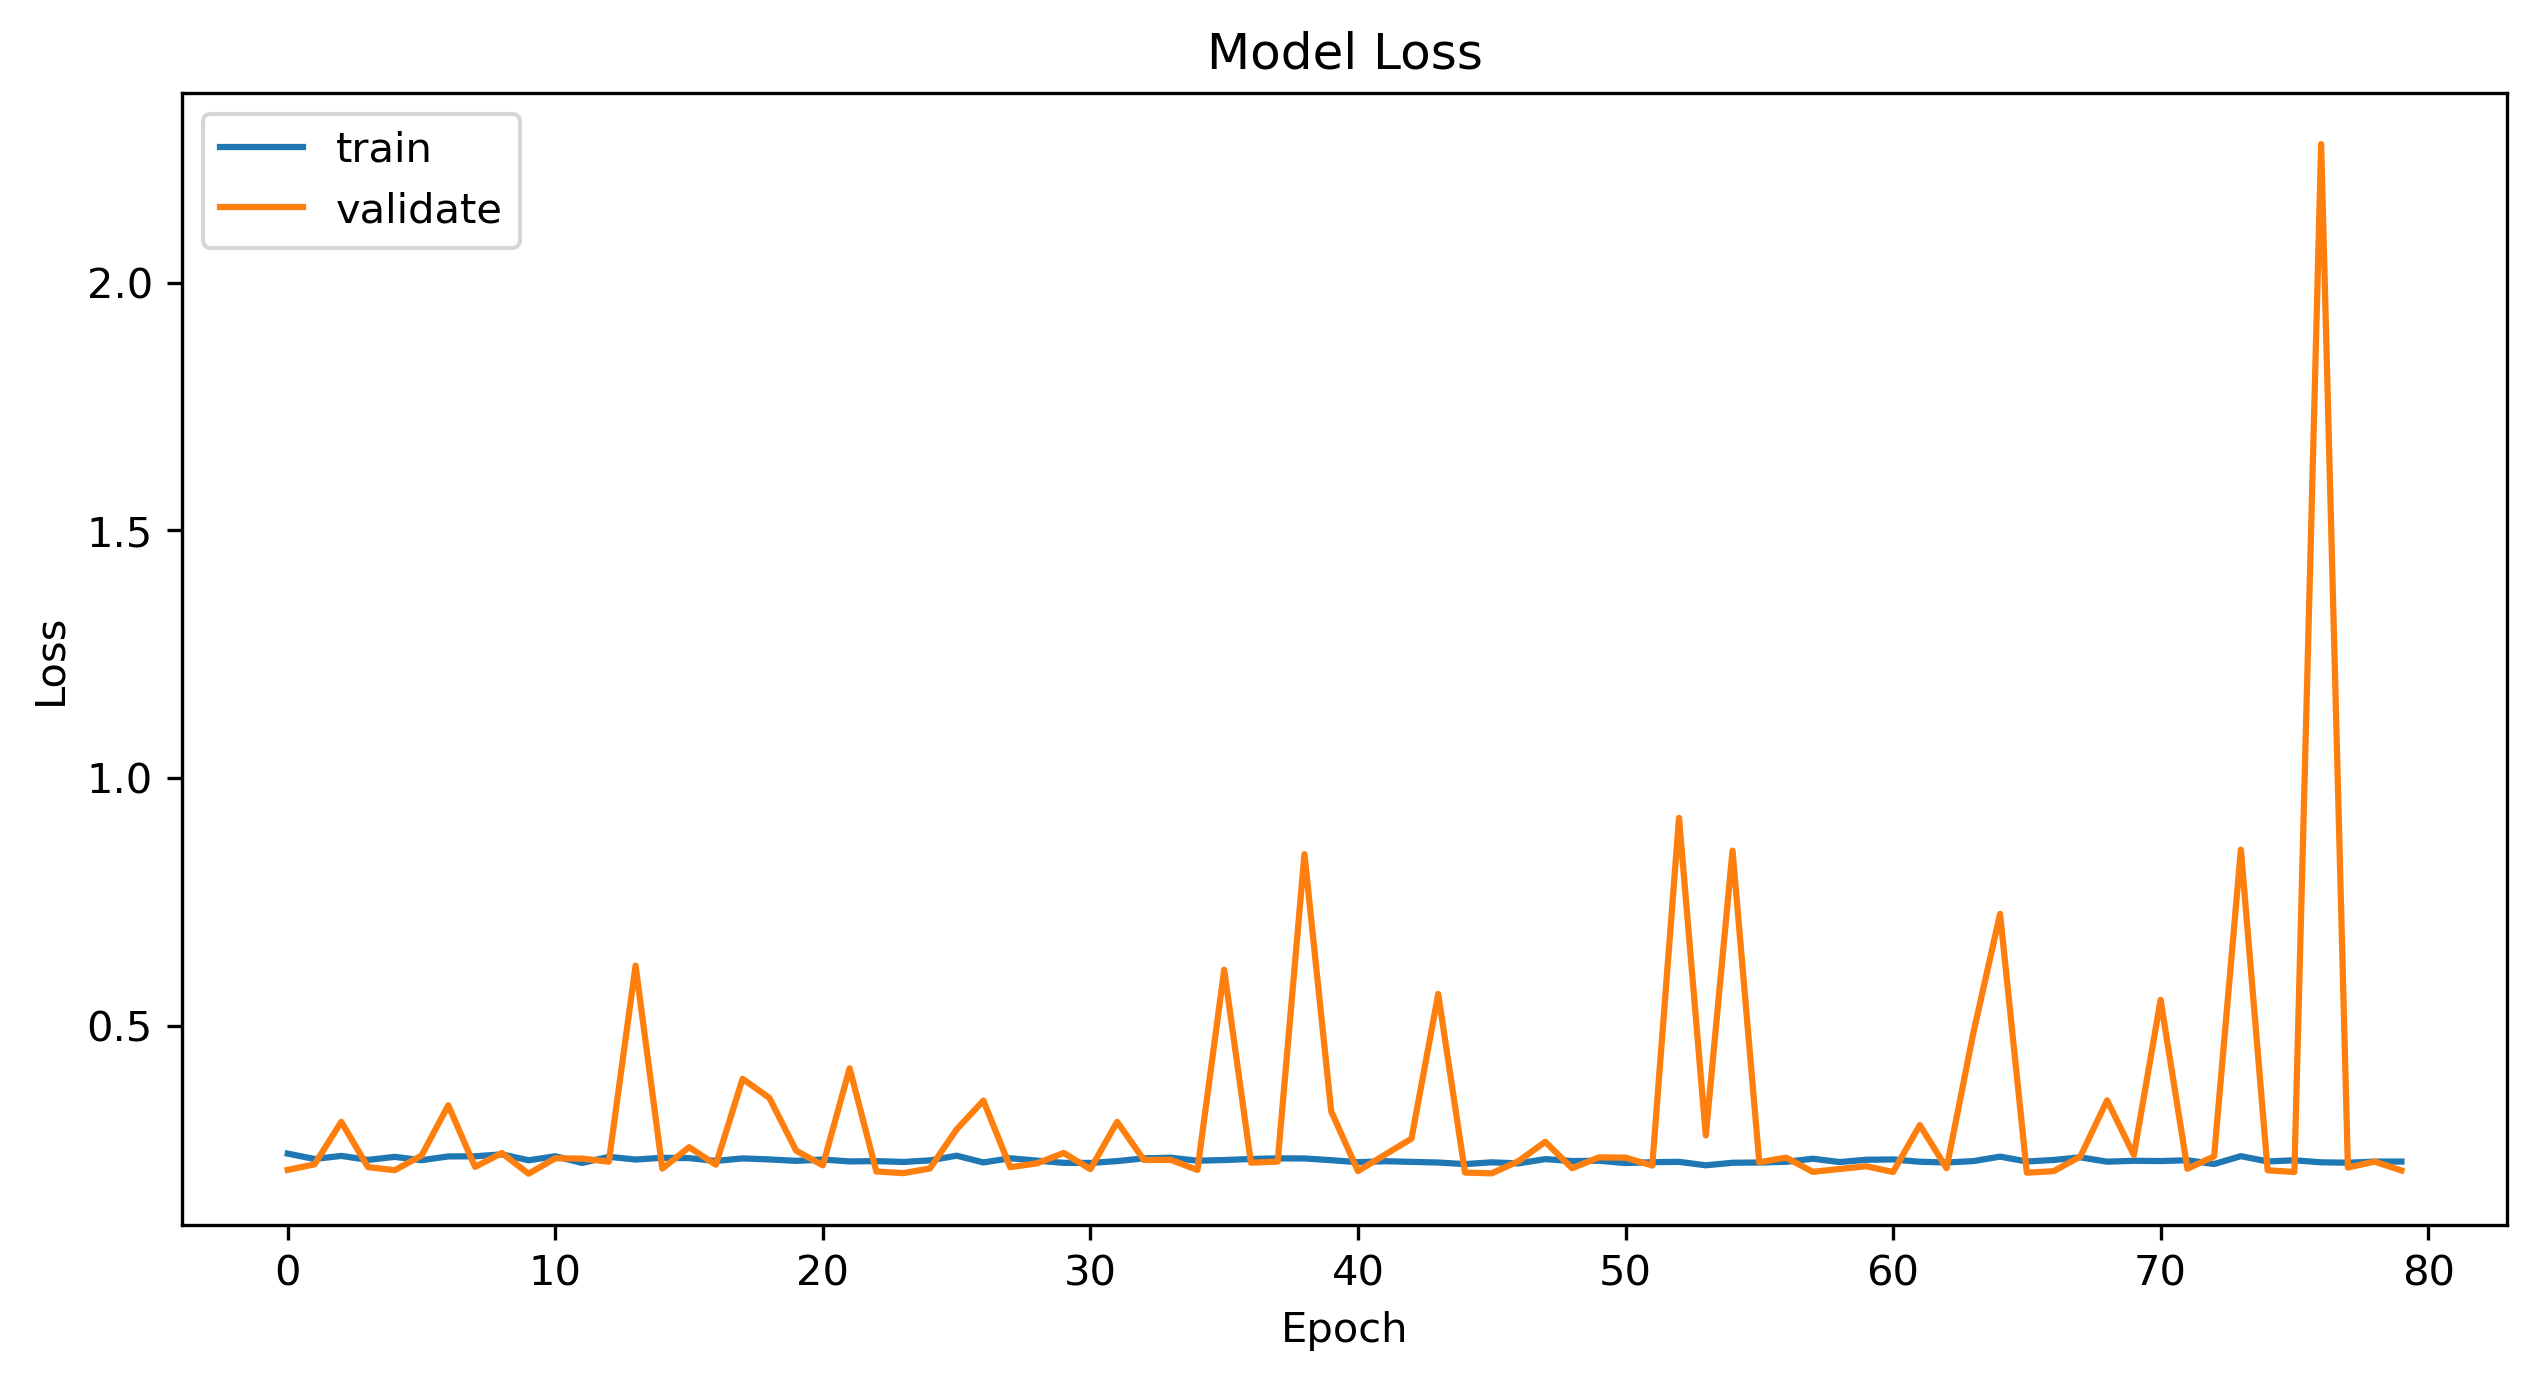

In [13]:
es = EarlyStopping(patience= 40, restore_best_weights=True, monitor="val_accuracy")

opt = SGD(learning_rate=0.0005)
model.compile(optimizer = opt,loss='categorical_crossentropy', metrics=["accuracy"]) 

model.load_weights('resnet_aug_1.h5')
history = model.fit(train_generator, batch_size = 16, epochs=80, validation_data=test_generator,workers=4,callbacks=[es])
model.save_weights('resnet_aug_2.h5')
hist_df = pd.DataFrame(history.history) 
hist_csv_file = 'resnet_aug_history_2.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)
    
print(history.history.keys())
plotmodelhistory(history,'stage_2')

Confusion Matrix


<Figure size 1080x1080 with 0 Axes>

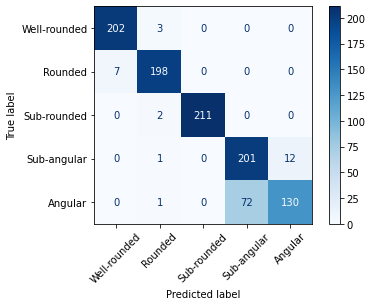

In [14]:
model.load_weights('resnet_aug_2.h5')
pred = model.predict(test_generator, steps=len(test_generator))
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
y_gen = np.argmax(testY, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(y_gen, y_pred);

target_names = ["Well-rounded", "Rounded", "Sub-rounded", "Sub-angular", "Angular"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
fig = plt.figure(figsize=(15,15))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.savefig("confussion_matrix.png",dpi=300,pad_inches=0.5,bbox_inches='tight')